In [3]:
import pandas as pd

There are two ways to scraping jiji. 

### 1. Using Beautiful soup to scroll as you scrap(This takes time)

In [309]:
import time
import csv
from selenium import webdriver
from bs4 import BeautifulSoup

class CarScraper:
    def __init__(self):
        self.driver = webdriver.Chrome()
        self.driver.get("https://jiji.co.ke/cars?sort=new")
        self.data_list = []
        self.scraped_set = set()

    def scrape_listing(self, listing):
        # Your scraping logic here
        # ...
    name = listing.find('div', class_='qa-advert-list-item-title b-list-advert-base__item-title').text.strip()
    price = listing.find('div', class_='qa-advert-price').text.strip()
    desc_elements = listing.find('div', class_='b-list-advert-base__item-attr__wrapper').find_all('div')
    desc = [element.text.strip() for element in desc_elements]

    name_parts = name.split()
    make = name_parts[0]
    model = ' '.join(name_parts[1:-3])
    year = name_parts[-2]
    color = name_parts[-1]

    foreign_local = desc[0]
    engine_type = desc[-1]

    data = {
        'Make': make,
        'Model': model,
        'Year': year,
        'Color': color,
        'Price': price,
        'Foreign/Local': foreign_local,
        'Engine Type': engine_type
    }
    return data

    def run(self):
        try:
            max_scrolls = 10
            for i in range(max_scrolls):
                # Scroll by a fixed height
                scroll_height = 1000 * i
                self.driver.execute_script("window.scrollTo(0, {scroll_height});".format(scroll_height=scroll_height))
                time.sleep(2)  # Allow time for new content to load dynamically
                soup = BeautifulSoup(self.driver.page_source, "html.parser")
                listing_divs = soup.find_all('div', class_='b-list-advert-base__data')

                for listing in listing_divs:
                    data = self.scrape_listing(listing)
                    if data is not None:
                        data_str = f"{data['Make']} {data['Model']} {data['Year']} {data['Color']}"
                        if data_str not in self.scraped_set:
                            self.data_list.append(data)
                            self.scraped_set.add(data_str)  # Add the unique identifier to the set

        finally:
            self.driver.quit()

        csv_filename = 'car_listings.csv'
        with open(csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
            fieldnames = ['Make', 'Model', 'Year', 'Color', 'Price', 'Foreign/Local', 'Engine Type']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for data in self.data_list:
                writer.writerow(data)

        print(f"Data exported to {csv_filename}")

if __name__ == "__main__":
    scraper = CarScraper()
    scraper.run()


IndentationError: expected an indented block after function definition on line 13 (4143306257.py, line 16)

### 2. Using the url with page numbers to iterate through the pages(memory intensive)

In [ ]:
from retry import retry
import requests


import time
import csv
from selenium import webdriver
from bs4 import BeautifulSoup


@retry(ConnectionError, delay=2, backoff=2, tries=5)
def fetch_car_listings(page_num):
    url = f"https://jiji.co.ke/api_web/v1/listing?sort=new&slug=cars&init_page=true&page={page_num}&webp=true&lsmid=1692735392160.."
    response = requests.get(url, allow_redirects=False)  # Disable automatic redirection
    if response.status_code == 301:  # Permanent redirect
        new_url = response.headers.get("Location")  # Get the new URL from the "Location" header
        response = requests.get(new_url)  # Fetch data from the new URL

    if response.status_code == 200:
        return response.json()
    else:
        return None

    
    
    # response = requests.get(url)
    # if response.status_code == 200:
    #     return response.json()
    # else:
    #     return None


def main():
    start_time = time.time()
    all_listings = []
    for page_num in range(1001,1010):  # Scrape data from page 1 to page 10
        listings_data = fetch_car_listings(page_num)
        if listings_data is None or not listings_data:
            break
        
        for listing in listings_data['adverts_list']['adverts']:
            title = listing.get('title', '')
            price = listing.get('price_obj', {}).get('view', '')
            
            attrs = listing.get('attrs', [])
            transmission = ''
            condition = ''
            mileage = ''
            
            for attr in attrs:
                if attr.get('name') == 'Transmission':
                    transmission = attr.get('value', '')
                elif attr.get('name') == 'Condition':
                    condition = attr.get('value', '')
                elif attr.get('name') == 'Mileage':
                    mileage = attr.get('value', '')
            
            title_parts = title.split()
            make = title_parts[0]
            model = title_parts[1]
            year = title_parts[-2] if title_parts[-1].isdigit() else title_parts[-1]
            color = title_parts[-1]
            
            if title_parts[-2].isnumeric() and len(title_parts[-2]) == 4:
                year = title_parts[-2]
            elif title_parts[-1].isnumeric() and len(title_parts[-1]) == 4:
                year = title_parts[-1]
            else:
                year = ""

        # Determine color
            if not title_parts[-1].isnumeric():
                color = title_parts[-1]
            else:
                color = ""

            
            
            data = {
                'Make': make,
                'Model': model,
                'Year': year,
                'Color': color,
                'Price': price,
                'Foreign/Local': condition,
                'Engine Type': transmission,
                'Mileage': mileage
            }
            all_listings.append(data)
    
    csv_filename = 'car_listings_1001_1200.csv'
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
        fieldnames = ['Make', 'Model', 'Year', 'Color', 'Price', 'Foreign/Local', 'Engine Type', 'Mileage']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for data in all_listings:
            writer.writerow(data)
    
    end_time = time.time() #Record the endtime
    elapsed_time = end_time - start_time
    print(f"Scraping com∂pleted in {elapsed_time:.2f} seconds")
if __name__ == "__main__":
    main()


### EDA

In [1]:
import pandas as pd

#### Join the two csv files and create a dataframe

In [2]:
df1 = pd.read_csv('car_listings_500.csv')
df2 = pd.read_csv('car_listings_501_1000.csv')
df = pd.concat([df1,df2]).reset_index(drop=True)

In [3]:
df

,Make,Model,Year,Color,Price,Foreign/Local,Engine Type,Mileage
0,Nissan,Hardbody,2011.0,White,"KSh 1,200,000",Kenyan Used,Manual,NaN
1,Toyota,Hilux,2018.0,Gray,"KSh 2,399,000",Kenyan Used,Manual,NaN
2,Toyota,Hilux,2018.0,Gray,"KSh 2,700,000",Kenyan Used,Manual,NaN
3,Nissan,Advan,2010.0,Blue,"KSh 450,000",Kenyan Used,Automatic,NaN
4,Toyota,Allion,2017.0,Burgundy,"KSh 2,150,000",Foreign Used,Automatic,78540.0
...,...,...,...,...,...,...,...,...
20453,Nissan,Leaf,2016.0,White,"KSh 1,600,000",Foreign Used,Automatic,67000.0
20454,Toyota,Passo,2016.0,NaN,"KSh 1,000,000",Foreign Used,Automatic,73000.0
20455,Volvo,XC90,2016.0,White,"KSh 6,500,000",Foreign Used,Automatic,NaN
20456,Honda,Fit,2017.0,Silver,"KSh 1,750,000",Foreign Used,Automatic,56387.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20458 entries, 0 to 20457
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           20458 non-null  object 
 1   Model          20458 non-null  object 
 2   Year           20254 non-null  float64
 3   Color          20296 non-null  object 
 4   Price          20458 non-null  object 
 5   Foreign/Local  20458 non-null  object 
 6   Engine Type    20458 non-null  object 
 7   Mileage        13048 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.2+ MB


df

Check for missing data

In [5]:
df.isna().sum()/df.count()*100

Make              0.000000
Model             0.000000
Year              1.007208
Color             0.798187
Price             0.000000
Foreign/Local     0.000000
Engine Type       0.000000
Mileage          56.790313
dtype: float64

In [6]:
df.isna().sum()

Make                0
Model               0
Year              204
Color             162
Price               0
Foreign/Local       0
Engine Type         0
Mileage          7410
dtype: int64

In [9]:
df.Price = df.Price.str.replace('[^\d.]','', regex=True)

In [10]:
df.Price = df.Price.astype('int')

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df['Year'] = df['Year'].astype('str')
df['Year'] = df['Year'].str.replace('.0', '')

In [13]:
columns_to_exclude = ['Price','Mileage']

for i in df.columns:
    if i not in columns_to_exclude:
        df[i] = df[i].astype('category')

In [14]:
df.Make.value_counts().head(10).index

CategoricalIndex(['Toyota', 'Nissan', 'Subaru', 'Mazda', 'Honda',
                  'Mercedes-Benz', 'Mitsubishi', 'Volkswagen', 'Suzuki',
                  'BMW'],
                 categories=['Alfa', 'Audi', 'BMW', 'Bentley', ..., 'Tata', 'Toyota', 'Volkswagen', 'Volvo'], ordered=False, dtype='category', name='Make')

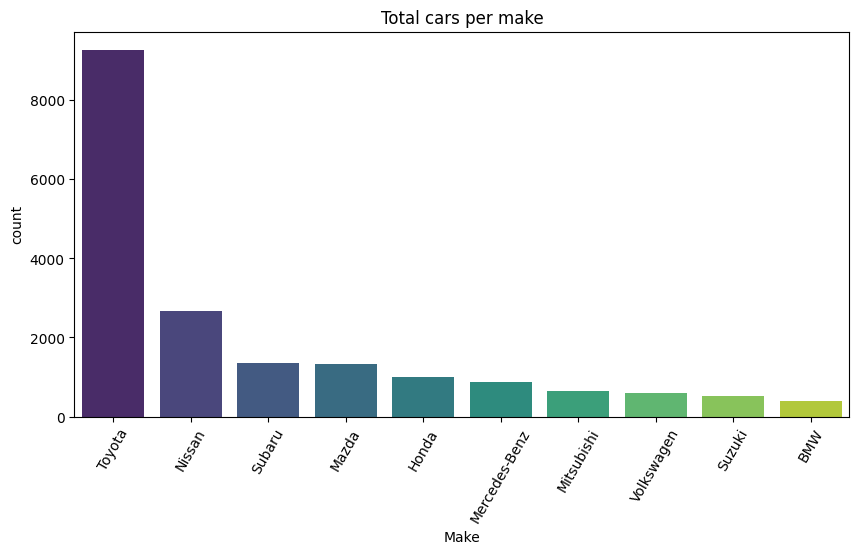

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Make', palette ='viridis' ,order=df.Make.value_counts().head(10).index)
plt.xticks(rotation=60)
plt.title('Total cars per make')
plt.show()

In [16]:
df[df.Make.isna()]

,Make,Model,Year,Color,Price,Foreign/Local,Engine Type,Mileage


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20458 entries, 0 to 20457
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Make           20458 non-null  category
 1   Model          20458 non-null  category
 2   Year           20458 non-null  category
 3   Color          20296 non-null  category
 4   Price          20458 non-null  int64   
 5   Foreign/Local  20458 non-null  category
 6   Engine Type    20458 non-null  category
 7   Mileage        13048 non-null  float64 
dtypes: category(6), float64(1), int64(1)
memory usage: 484.3 KB


In [18]:
df.Year.value_counts().head(5)

Year
2016    5478
2015    1818
2014    1410
2012    1353
2017    1162
Name: count, dtype: int64

<Axes: xlabel='Year', ylabel='count'>

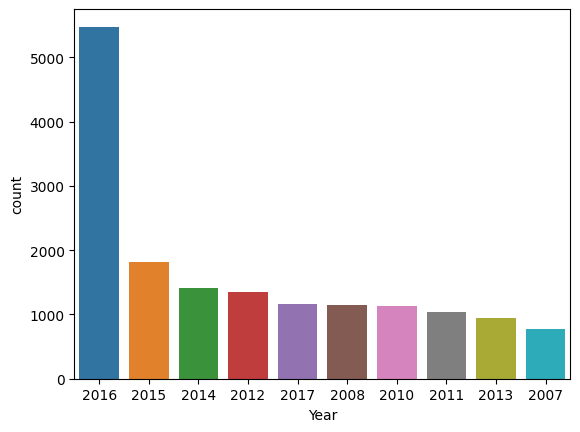

In [19]:
sns.countplot(data=df, x='Year' ,order=df.Year.value_counts().head(10).index)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20458 entries, 0 to 20457
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Make           20458 non-null  category
 1   Model          20458 non-null  category
 2   Year           20458 non-null  category
 3   Color          20296 non-null  category
 4   Price          20458 non-null  int64   
 5   Foreign/Local  20458 non-null  category
 6   Engine Type    20458 non-null  category
 7   Mileage        13048 non-null  float64 
dtypes: category(6), float64(1), int64(1)
memory usage: 484.3 KB


In [21]:
df[df['Year'].isna()]

,Make,Model,Year,Color,Price,Foreign/Local,Engine Type,Mileage


In [22]:
df_cleaned = df.dropna(subset=['Year'])

In [23]:
df_cleaned

,Make,Model,Year,Color,Price,Foreign/Local,Engine Type,Mileage
0,Nissan,Hardbody,2011,White,1200000,Kenyan Used,Manual,NaN
1,Toyota,Hilux,2018,Gray,2399000,Kenyan Used,Manual,NaN
2,Toyota,Hilux,2018,Gray,2700000,Kenyan Used,Manual,NaN
3,Nissan,Advan,2010,Blue,450000,Kenyan Used,Automatic,NaN
4,Toyota,Allion,2017,Burgundy,2150000,Foreign Used,Automatic,78540.0
...,...,...,...,...,...,...,...,...
20453,Nissan,Leaf,2016,White,1600000,Foreign Used,Automatic,67000.0
20454,Toyota,Passo,2016,NaN,1000000,Foreign Used,Automatic,73000.0
20455,Volvo,XC90,2016,White,6500000,Foreign Used,Automatic,NaN
20456,Honda,Fit,2017,Silver,1750000,Foreign Used,Automatic,56387.0


In [24]:
df.Color.value_counts()

Color
White       5362
Silver      4209
Black       3891
Blue        1627
Gray        1605
Red         1086
Pearl        545
Brown        406
Green        300
Gold         292
Purple       231
Beige        219
Burgundy     144
white        111
Orange        82
Pink          68
Yellow        49
Teal          34
Ivory         32
Whtie          2
Burgandy       1
Name: count, dtype: int64

In [25]:
df.Color.isna().sum()

162

In [26]:
df_cleaned = df_cleaned.dropna(subset=['Color'])

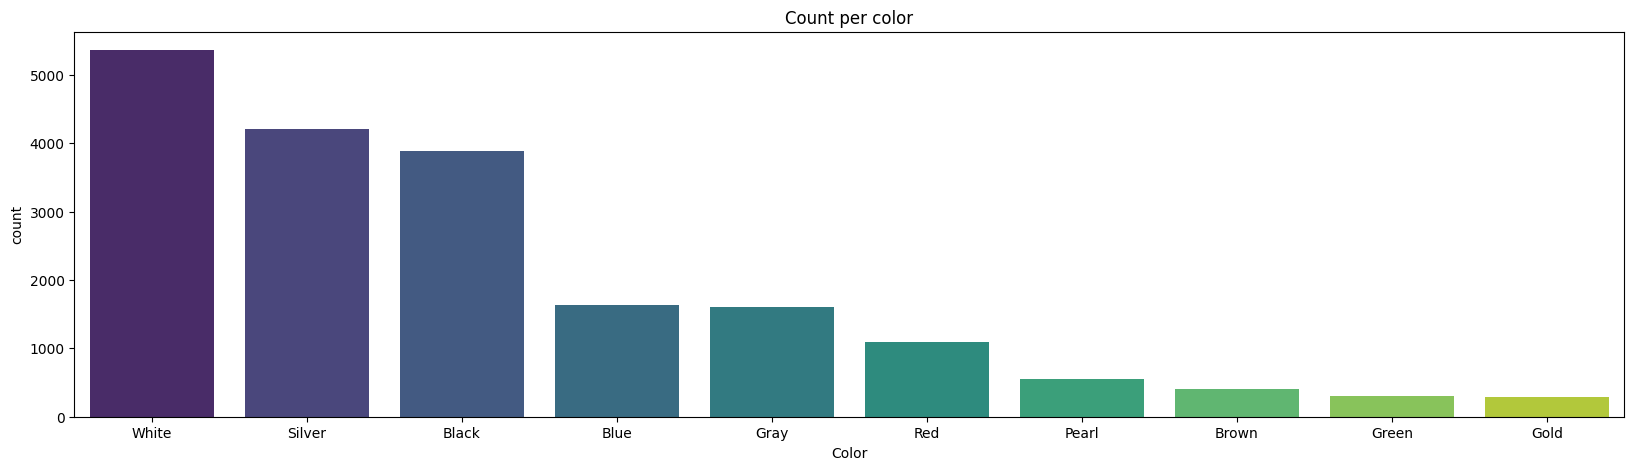

In [27]:
plt.figure(figsize=[20,5])
sns.countplot(data=df_cleaned, x='Color', palette='viridis', order=df_cleaned.Color.value_counts().head(10).index)
plt.title('Count per color')
plt.show()

In [28]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20296 entries, 0 to 20457
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Make           20296 non-null  category
 1   Model          20296 non-null  category
 2   Year           20296 non-null  category
 3   Color          20296 non-null  category
 4   Price          20296 non-null  int64   
 5   Foreign/Local  20296 non-null  category
 6   Engine Type    20296 non-null  category
 7   Mileage        12948 non-null  float64 
dtypes: category(6), float64(1), int64(1)
memory usage: 639.1 KB


/var/folders/dk/r2b4drkd1yxgp0b14lryzqz00000gn/T/ipykernel_15285/2041128712.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_cleaned, x='Price', palette='viridis',bins=30)


<function matplotlib.pyplot.show(close=None, block=None)>

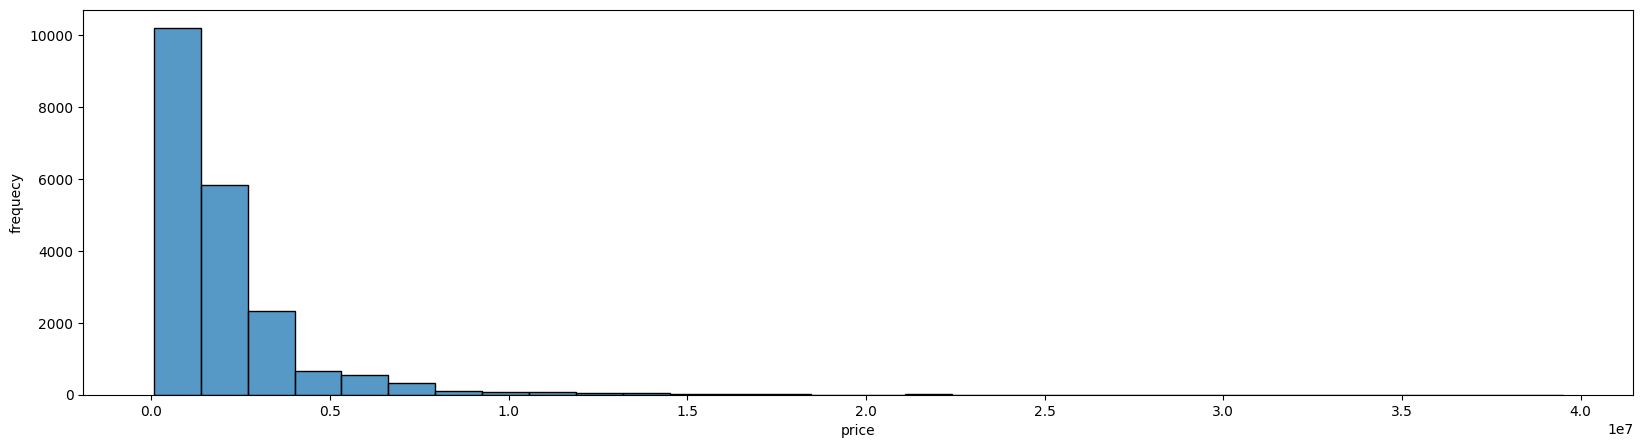

In [29]:
plt.figure(figsize=[20,5])
sns.histplot(data=df_cleaned, x='Price', palette='viridis',bins=30)
plt.xlabel('price')
plt.ylabel('frequecy')
plt.show

#### We'll leave Mileage out of the training data because a. It can be tampered with, b.Half of the data is missing

### Feature Selection

In [30]:
categorical_df = df_cleaned.select_dtypes(include=['category'])

In [32]:
print(categorical_df)

         Make     Model  Year     Color Foreign/Local Engine Type
0      Nissan  Hardbody  2011     White   Kenyan Used      Manual
1      Toyota     Hilux  2018      Gray   Kenyan Used      Manual
2      Toyota     Hilux  2018      Gray   Kenyan Used      Manual
3      Nissan     Advan  2010      Blue   Kenyan Used   Automatic
4      Toyota    Allion  2017  Burgundy  Foreign Used   Automatic
...       ...       ...   ...       ...           ...         ...
20452  Toyota      Land  2012      Gray   Kenyan Used   Automatic
20453  Nissan      Leaf  2016     White  Foreign Used   Automatic
20455   Volvo      XC90  2016     White  Foreign Used   Automatic
20456   Honda       Fit  2017    Silver  Foreign Used   Automatic
20457  Toyota      Land  2000     White   Kenyan Used   Automatic

[20296 rows x 6 columns]


In [33]:
df_cleaned

,Make,Model,Year,Color,Price,Foreign/Local,Engine Type,Mileage
0,Nissan,Hardbody,2011,White,1200000,Kenyan Used,Manual,NaN
1,Toyota,Hilux,2018,Gray,2399000,Kenyan Used,Manual,NaN
2,Toyota,Hilux,2018,Gray,2700000,Kenyan Used,Manual,NaN
3,Nissan,Advan,2010,Blue,450000,Kenyan Used,Automatic,NaN
4,Toyota,Allion,2017,Burgundy,2150000,Foreign Used,Automatic,78540.0
...,...,...,...,...,...,...,...,...
20452,Toyota,Land,2012,Gray,6700000,Kenyan Used,Automatic,NaN
20453,Nissan,Leaf,2016,White,1600000,Foreign Used,Automatic,67000.0
20455,Volvo,XC90,2016,White,6500000,Foreign Used,Automatic,NaN
20456,Honda,Fit,2017,Silver,1750000,Foreign Used,Automatic,56387.0


In [36]:
X = categorical_df
y = df_cleaned['Price']

In [53]:
categorical_columns

['Make', 'Model', 'Year', 'Color', 'Foreign/Local', 'Engine Type']

In [38]:
X = pd.get_dummies(X,columns=categorical_columns, prefix = categorical_columns)

In [39]:
X

,Make_Alfa,Make_Audi,Make_BMW,Make_Bentley,Make_Car,Make_Chery,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Daihatsu,...,Color_Whtie,Color_Yellow,Color_white,Foreign/Local_Brand New,Foreign/Local_Foreign Used,Foreign/Local_Kenyan Used,Engine Type_AMT,Engine Type_Automatic,Engine Type_CVT,Engine Type_Manual
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20452,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
20453,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
20455,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
20456,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


In [40]:
y.shape

(20296,)

### Model Training

In [41]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train, X_test , Y_train, Y_test = train_test_split(X,y ,test_size=0.2, random_state= 42)

In [42]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error  # Import the mean_squared_error function
from sklearn.model_selection import train_test_split



def objective(trial, X,y):
    X_train, X_test , Y_train, Y_test = train_test_split(X,y ,test_size=0.2, random_state= 42)
    param ={
                'eta':trial.suggest_float('eta', 0.005, 0.01),
                'n_estimators': trial.suggest_int('n_estimators',400,2000), 
                'max_depth':trial.suggest_int('max_depth' ,7,9),
                'reg_alpha':trial.suggest_float('reg_alpha',0.00, 1),
                'reg_lambda':trial.suggest_float('reg_lambda',0.5,1.5),
                'min_child_weight':trial.suggest_float('min_child_weight',1,3),
                'tweedie_p':trial.suggest_float('tweedie_p',0.01,2),
                'learning_rate':trial.suggest_float('learning_rate', 0.005,0.1),
                'col_sample_by_tree':trial.suggest_float('col_sample_by_tree',0.1,2), 
                'n_thread': -1,
                'early_stopping_rounds':5
    }
    
    model = XGBRegressor()
    model.set_params(**param)
    
    model.fit(X_train, Y_train, eval_set = [(X_test, Y_test)], verbose = 0)
    
    y_preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(Y_test,y_preds))

In [75]:
%time 

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial : objective(trial, X_train, Y_train), n_trials = 50)

[I 2023-09-03 01:26:44,128] A new study created in memory with name: no-name-1762c15a-e482-4e6d-91cd-580a3832e740


CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 16.2 µs
[01:26:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:27:16,857] Trial 0 finished with value: 1002696.8511751825 and parameters: {'eta': 0.0062420201362160714, 'n_estimators': 1041, 'max_depth': 7, 'reg_alpha': 0.8192833881599895, 'reg_lambda': 0.7947361251499132, 'min_child_weight': 1.711305530524997, 'tweedie_p': 0.10399497871708668, 'learning_rate': 0.025931188730648782, 'col_sample_by_tree': 1.5355486273674854}. Best is trial 0 with value: 1002696.8511751825.


[01:27:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:27:42,839] Trial 1 finished with value: 1005633.9106839511 and parameters: {'eta': 0.0069987557621288, 'n_estimators': 1617, 'max_depth': 9, 'reg_alpha': 0.08563818457328931, 'reg_lambda': 1.2301826881720843, 'min_child_weight': 2.2910844697665613, 'tweedie_p': 0.43211451067678397, 'learning_rate': 0.05991381895843311, 'col_sample_by_tree': 0.5507796231887009}. Best is trial 0 with value: 1002696.8511751825.


[01:27:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:27:55,716] Trial 2 finished with value: 1041263.3138355721 and parameters: {'eta': 0.005293677830633555, 'n_estimators': 1052, 'max_depth': 7, 'reg_alpha': 0.9843093067765343, 'reg_lambda': 0.713348658931109, 'min_child_weight': 2.5135626590797973, 'tweedie_p': 1.6976947485679883, 'learning_rate': 0.08887036294043221, 'col_sample_by_tree': 1.5490560620312528}. Best is trial 0 with value: 1002696.8511751825.


[01:27:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:28:04,690] Trial 3 finished with value: 1052714.1363322998 and parameters: {'eta': 0.00988621858877456, 'n_estimators': 515, 'max_depth': 8, 'reg_alpha': 0.6054219146903553, 'reg_lambda': 0.6085099801825983, 'min_child_weight': 2.7663991941108614, 'tweedie_p': 0.6882778170373786, 'learning_rate': 0.09786587518805734, 'col_sample_by_tree': 0.6452775049415467}. Best is trial 0 with value: 1002696.8511751825.


[01:28:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:28:14,989] Trial 4 finished with value: 997291.3097468942 and parameters: {'eta': 0.007497428055213096, 'n_estimators': 1609, 'max_depth': 7, 'reg_alpha': 0.6566279314792486, 'reg_lambda': 1.3214600148415452, 'min_child_weight': 1.9187050766556382, 'tweedie_p': 1.1406396071832767, 'learning_rate': 0.09765287702996364, 'col_sample_by_tree': 0.4967417766701768}. Best is trial 4 with value: 997291.3097468942.


[01:28:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:28:40,168] Trial 5 finished with value: 1052111.779715226 and parameters: {'eta': 0.005974487623090716, 'n_estimators': 1031, 'max_depth': 8, 'reg_alpha': 0.5202468237011485, 'reg_lambda': 1.0832158177578233, 'min_child_weight': 1.1400772535485475, 'tweedie_p': 1.222408597414647, 'learning_rate': 0.03694636285376181, 'col_sample_by_tree': 1.9515270864861551}. Best is trial 4 with value: 997291.3097468942.


[01:28:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:29:06,083] Trial 6 finished with value: 989456.4673677325 and parameters: {'eta': 0.007937007605268918, 'n_estimators': 494, 'max_depth': 7, 'reg_alpha': 0.9569641334547504, 'reg_lambda': 0.6839484108412865, 'min_child_weight': 1.5251614875891353, 'tweedie_p': 0.5442396094894971, 'learning_rate': 0.037445963966025245, 'col_sample_by_tree': 1.6022495448948748}. Best is trial 6 with value: 989456.4673677325.


[01:29:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:30:35,489] Trial 7 finished with value: 1007026.2785787535 and parameters: {'eta': 0.009609802378295368, 'n_estimators': 1882, 'max_depth': 7, 'reg_alpha': 0.26389206547953914, 'reg_lambda': 1.4867358320196173, 'min_child_weight': 1.131070686561758, 'tweedie_p': 1.3487741907805337, 'learning_rate': 0.0094155699598576, 'col_sample_by_tree': 1.564021577748004}. Best is trial 6 with value: 989456.4673677325.


[01:30:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:30:56,044] Trial 8 finished with value: 1037426.155776888 and parameters: {'eta': 0.007533922280471, 'n_estimators': 1784, 'max_depth': 8, 'reg_alpha': 0.47770927971936605, 'reg_lambda': 0.8399308848418872, 'min_child_weight': 1.7826915518999848, 'tweedie_p': 1.8573875007944407, 'learning_rate': 0.06930955845439657, 'col_sample_by_tree': 1.2693980595290992}. Best is trial 6 with value: 989456.4673677325.


[01:30:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:31:29,008] Trial 9 finished with value: 1064244.234003626 and parameters: {'eta': 0.006417392402377429, 'n_estimators': 1539, 'max_depth': 8, 'reg_alpha': 0.8730091699256863, 'reg_lambda': 1.2878254096704325, 'min_child_weight': 1.7558590493889366, 'tweedie_p': 0.5465662254019176, 'learning_rate': 0.027733099984683648, 'col_sample_by_tree': 0.6136934530079644}. Best is trial 6 with value: 989456.4673677325.


[01:31:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:31:51,164] Trial 10 finished with value: 1043164.9436396149 and parameters: {'eta': 0.008583901009657183, 'n_estimators': 417, 'max_depth': 9, 'reg_alpha': 0.7604313922460287, 'reg_lambda': 0.5035233341615446, 'min_child_weight': 1.3981995480933822, 'tweedie_p': 0.8199895888265385, 'learning_rate': 0.049989984503055564, 'col_sample_by_tree': 1.0519579149438467}. Best is trial 6 with value: 989456.4673677325.


[01:31:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:32:06,564] Trial 11 finished with value: 1018486.8095701131 and parameters: {'eta': 0.007908556006269024, 'n_estimators': 1394, 'max_depth': 7, 'reg_alpha': 0.9861908296221451, 'reg_lambda': 0.9581689743339463, 'min_child_weight': 2.0594782906061693, 'tweedie_p': 1.047417148333523, 'learning_rate': 0.07952074096199431, 'col_sample_by_tree': 0.12560938605528782}. Best is trial 6 with value: 989456.4673677325.


[01:32:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:32:20,512] Trial 12 finished with value: 993879.7648822439 and parameters: {'eta': 0.008336198006147362, 'n_estimators': 714, 'max_depth': 7, 'reg_alpha': 0.6829582642408869, 'reg_lambda': 0.9983884434542066, 'min_child_weight': 1.5198833371494056, 'tweedie_p': 0.9410741325365817, 'learning_rate': 0.07319905784022379, 'col_sample_by_tree': 1.9458973523903489}. Best is trial 6 with value: 989456.4673677325.


[01:32:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:32:38,015] Trial 13 finished with value: 985199.5263301084 and parameters: {'eta': 0.008427588223959111, 'n_estimators': 702, 'max_depth': 7, 'reg_alpha': 0.7495105720788556, 'reg_lambda': 0.8622404948504696, 'min_child_weight': 1.4376824188311386, 'tweedie_p': 0.8485943743128525, 'learning_rate': 0.05279536851247864, 'col_sample_by_tree': 1.9672809005218355}. Best is trial 13 with value: 985199.5263301084.


[01:32:38] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:33:00,152] Trial 14 finished with value: 985073.3683932163 and parameters: {'eta': 0.008951146541913271, 'n_estimators': 697, 'max_depth': 7, 'reg_alpha': 0.8690450074906135, 'reg_lambda': 0.7135205645697251, 'min_child_weight': 1.4066024702651254, 'tweedie_p': 0.3419397119819132, 'learning_rate': 0.048405764646666787, 'col_sample_by_tree': 1.9749822206515584}. Best is trial 14 with value: 985073.3683932163.


[01:33:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:33:20,009] Trial 15 finished with value: 1069082.4428714968 and parameters: {'eta': 0.008990545718126674, 'n_estimators': 762, 'max_depth': 8, 'reg_alpha': 0.8045182897383528, 'reg_lambda': 0.843539497626799, 'min_child_weight': 1.0562254189765652, 'tweedie_p': 0.25718503278874516, 'learning_rate': 0.05565623850096395, 'col_sample_by_tree': 1.9929509135478205}. Best is trial 14 with value: 985073.3683932163.


[01:33:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:33:38,763] Trial 16 finished with value: 997649.0056630875 and parameters: {'eta': 0.008942991866779083, 'n_estimators': 779, 'max_depth': 7, 'reg_alpha': 0.8589945991235074, 'reg_lambda': 0.9020717216647761, 'min_child_weight': 1.2793054671653534, 'tweedie_p': 0.017262232236903374, 'learning_rate': 0.04982184196405933, 'col_sample_by_tree': 1.776368914001314}. Best is trial 14 with value: 985073.3683932163.


[01:33:38] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:33:57,981] Trial 17 finished with value: 1037074.4450070249 and parameters: {'eta': 0.009386592276557658, 'n_estimators': 1230, 'max_depth': 9, 'reg_alpha': 0.7341472100350728, 'reg_lambda': 0.749196313339255, 'min_child_weight': 1.3495269279390452, 'tweedie_p': 0.3290690498167626, 'learning_rate': 0.06270805909529037, 'col_sample_by_tree': 1.7212452177977446}. Best is trial 14 with value: 985073.3683932163.


[01:33:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:34:22,490] Trial 18 finished with value: 975863.6321086347 and parameters: {'eta': 0.00924345599597943, 'n_estimators': 659, 'max_depth': 7, 'reg_alpha': 0.5519441156783874, 'reg_lambda': 1.0704568293318233, 'min_child_weight': 1.0117619024555289, 'tweedie_p': 0.7127880864049806, 'learning_rate': 0.04435566782436646, 'col_sample_by_tree': 1.3976668048839411}. Best is trial 18 with value: 975863.6321086347.


[01:34:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:34:47,095] Trial 19 finished with value: 1049305.274691461 and parameters: {'eta': 0.009960480190708202, 'n_estimators': 872, 'max_depth': 8, 'reg_alpha': 0.48906863010961715, 'reg_lambda': 1.0743889387137278, 'min_child_weight': 1.0115676260918114, 'tweedie_p': 0.6190261005444105, 'learning_rate': 0.04346212362762028, 'col_sample_by_tree': 1.3622006055486016}. Best is trial 18 with value: 975863.6321086347.


[01:34:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:35:17,829] Trial 20 finished with value: 953373.9424255425 and parameters: {'eta': 0.009233659977987389, 'n_estimators': 592, 'max_depth': 7, 'reg_alpha': 0.35436919601835526, 'reg_lambda': 1.0982764539344845, 'min_child_weight': 1.1946198659847957, 'tweedie_p': 0.23549932507140064, 'learning_rate': 0.061570394381627716, 'col_sample_by_tree': 1.3233046386582328}. Best is trial 20 with value: 953373.9424255425.


[01:35:17] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:35:31,534] Trial 21 finished with value: 1009816.4913842111 and parameters: {'eta': 0.00919556607315954, 'n_estimators': 626, 'max_depth': 7, 'reg_alpha': 0.3438666957414568, 'reg_lambda': 1.0868460103606703, 'min_child_weight': 1.014977273296121, 'tweedie_p': 0.26216975752401694, 'learning_rate': 0.06425730864363118, 'col_sample_by_tree': 1.2146672194744847}. Best is trial 20 with value: 953373.9424255425.


[01:35:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:35:52,130] Trial 22 finished with value: 975284.707055535 and parameters: {'eta': 0.00895866002583902, 'n_estimators': 897, 'max_depth': 7, 'reg_alpha': 0.5930441853984998, 'reg_lambda': 0.9704615349336644, 'min_child_weight': 1.1958247838079452, 'tweedie_p': 0.3925354942294511, 'learning_rate': 0.05767721542837775, 'col_sample_by_tree': 1.353898969057415}. Best is trial 20 with value: 953373.9424255425.


[01:35:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:36:06,498] Trial 23 finished with value: 992769.6815301428 and parameters: {'eta': 0.009464456056756282, 'n_estimators': 905, 'max_depth': 7, 'reg_alpha': 0.581795662261639, 'reg_lambda': 0.9471053062546789, 'min_child_weight': 1.2164883739718777, 'tweedie_p': 0.14796442457829462, 'learning_rate': 0.07159018363430754, 'col_sample_by_tree': 1.4088159274338956}. Best is trial 20 with value: 953373.9424255425.


[01:36:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:36:40,064] Trial 24 finished with value: 1011286.2654403343 and parameters: {'eta': 0.008713099651651419, 'n_estimators': 569, 'max_depth': 8, 'reg_alpha': 0.4054333746709321, 'reg_lambda': 1.1445095046531542, 'min_child_weight': 1.156225604131226, 'tweedie_p': 0.43642371630760846, 'learning_rate': 0.05887858015514833, 'col_sample_by_tree': 1.1239252361181207}. Best is trial 20 with value: 953373.9424255425.


[01:36:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:36:54,801] Trial 25 finished with value: 982878.0539353243 and parameters: {'eta': 0.009452414067375455, 'n_estimators': 888, 'max_depth': 7, 'reg_alpha': 0.5690766001840407, 'reg_lambda': 1.0039915371354675, 'min_child_weight': 1.2292811154942078, 'tweedie_p': 0.7334337656087112, 'learning_rate': 0.0803175329341721, 'col_sample_by_tree': 0.9462092425553861}. Best is trial 20 with value: 953373.9424255425.


[01:36:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:37:20,910] Trial 26 finished with value: 951937.9900798283 and parameters: {'eta': 0.009721986530611645, 'n_estimators': 1199, 'max_depth': 7, 'reg_alpha': 0.4292779022505494, 'reg_lambda': 1.151946743331723, 'min_child_weight': 1.5651313511410236, 'tweedie_p': 0.48036329316869375, 'learning_rate': 0.06334203001718318, 'col_sample_by_tree': 1.3570704848196897}. Best is trial 26 with value: 951937.9900798283.


[01:37:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:37:46,554] Trial 27 finished with value: 958773.9636219897 and parameters: {'eta': 0.009848820903421145, 'n_estimators': 1219, 'max_depth': 7, 'reg_alpha': 0.42153885807516756, 'reg_lambda': 0.914943588997635, 'min_child_weight': 1.5348162993339671, 'tweedie_p': 0.44517359726405403, 'learning_rate': 0.06508459420028023, 'col_sample_by_tree': 1.2229824840722667}. Best is trial 26 with value: 951937.9900798283.


[01:37:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:38:01,769] Trial 28 finished with value: 1058016.3350828036 and parameters: {'eta': 0.009996828219992003, 'n_estimators': 1230, 'max_depth': 8, 'reg_alpha': 0.27872865842749184, 'reg_lambda': 1.1738723055879177, 'min_child_weight': 1.564431478169563, 'tweedie_p': 0.15597634368884433, 'learning_rate': 0.06590815059803525, 'col_sample_by_tree': 0.9421623854317124}. Best is trial 26 with value: 951937.9900798283.


[01:38:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:38:25,216] Trial 29 finished with value: 924232.3660646222 and parameters: {'eta': 0.009684010308628093, 'n_estimators': 1365, 'max_depth': 7, 'reg_alpha': 0.42438564815597984, 'reg_lambda': 0.9251017847335631, 'min_child_weight': 1.610491507956795, 'tweedie_p': 0.06557862192464337, 'learning_rate': 0.07740472713506107, 'col_sample_by_tree': 1.2001449477167179}. Best is trial 29 with value: 924232.3660646222.


[01:38:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:38:42,032] Trial 30 finished with value: 953746.3469207293 and parameters: {'eta': 0.009633408039191362, 'n_estimators': 1422, 'max_depth': 7, 'reg_alpha': 0.20887786964293611, 'reg_lambda': 1.154723544544578, 'min_child_weight': 1.647359913433159, 'tweedie_p': 0.21499075612347718, 'learning_rate': 0.07941549368379108, 'col_sample_by_tree': 1.1386246390608383}. Best is trial 29 with value: 924232.3660646222.


[01:38:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:38:52,785] Trial 31 finished with value: 992694.0086775051 and parameters: {'eta': 0.009605758459400544, 'n_estimators': 1395, 'max_depth': 7, 'reg_alpha': 0.30143592627956767, 'reg_lambda': 1.16663874705389, 'min_child_weight': 1.6982714472433875, 'tweedie_p': 0.01078818165530171, 'learning_rate': 0.07788105422584399, 'col_sample_by_tree': 1.1484224552407005}. Best is trial 29 with value: 924232.3660646222.


[01:38:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:39:03,908] Trial 32 finished with value: 991819.683058567 and parameters: {'eta': 0.009706020352357807, 'n_estimators': 1379, 'max_depth': 7, 'reg_alpha': 0.2180345491875545, 'reg_lambda': 1.0237615990158948, 'min_child_weight': 1.6637207441157853, 'tweedie_p': 0.15622351943110682, 'learning_rate': 0.08387547971713834, 'col_sample_by_tree': 1.424419890867892}. Best is trial 29 with value: 924232.3660646222.


[01:39:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:39:18,502] Trial 33 finished with value: 989136.7946464521 and parameters: {'eta': 0.009254562728988378, 'n_estimators': 1075, 'max_depth': 7, 'reg_alpha': 0.18539453092161437, 'reg_lambda': 1.2336818577679707, 'min_child_weight': 1.9153149577757094, 'tweedie_p': 0.20995883059131754, 'learning_rate': 0.07240166297605669, 'col_sample_by_tree': 1.2599821075819466}. Best is trial 29 with value: 924232.3660646222.


[01:39:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:39:43,230] Trial 34 finished with value: 936035.1735741625 and parameters: {'eta': 0.009588106990570585, 'n_estimators': 1493, 'max_depth': 7, 'reg_alpha': 0.10455955569411557, 'reg_lambda': 1.1234454050215514, 'min_child_weight': 1.6202019358553548, 'tweedie_p': 0.0699256503514619, 'learning_rate': 0.08698081473603281, 'col_sample_by_tree': 1.0414129251369262}. Best is trial 29 with value: 924232.3660646222.


[01:39:43] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:40:00,583] Trial 35 finished with value: 961889.1675062623 and parameters: {'eta': 0.009964602222709394, 'n_estimators': 1713, 'max_depth': 7, 'reg_alpha': 0.05729708599095337, 'reg_lambda': 1.0451068960459433, 'min_child_weight': 1.3136061767429994, 'tweedie_p': 0.07935597807189987, 'learning_rate': 0.08929917924600014, 'col_sample_by_tree': 0.9519668867217747}. Best is trial 29 with value: 924232.3660646222.


[01:40:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:40:19,896] Trial 36 finished with value: 1024990.7107048534 and parameters: {'eta': 0.00969177698207048, 'n_estimators': 2000, 'max_depth': 9, 'reg_alpha': 0.07205872691024352, 'reg_lambda': 1.1089098418443144, 'min_child_weight': 1.8171369198111653, 'tweedie_p': 0.10198317768133894, 'learning_rate': 0.09298429562600666, 'col_sample_by_tree': 1.477585820930694}. Best is trial 29 with value: 924232.3660646222.


[01:40:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:40:33,631] Trial 37 finished with value: 1029061.3451232964 and parameters: {'eta': 0.009287307133062155, 'n_estimators': 1495, 'max_depth': 7, 'reg_alpha': 0.0075462761807626455, 'reg_lambda': 1.2194189140762206, 'min_child_weight': 2.0277085608671572, 'tweedie_p': 0.28537780394802753, 'learning_rate': 0.08655952074332036, 'col_sample_by_tree': 1.0288933132688065}. Best is trial 29 with value: 924232.3660646222.


[01:40:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:40:46,889] Trial 38 finished with value: 1055025.6302653821 and parameters: {'eta': 0.009682786907315766, 'n_estimators': 1307, 'max_depth': 8, 'reg_alpha': 0.14102603768561212, 'reg_lambda': 1.0273854589254268, 'min_child_weight': 1.622694045791108, 'tweedie_p': 0.5007495137913343, 'learning_rate': 0.09224412656253665, 'col_sample_by_tree': 0.8591729394060901}. Best is trial 29 with value: 924232.3660646222.


[01:40:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:40:56,250] Trial 39 finished with value: 1005379.6852209478 and parameters: {'eta': 0.008732187353214587, 'n_estimators': 1096, 'max_depth': 7, 'reg_alpha': 0.3527008966484397, 'reg_lambda': 1.1205401920070879, 'min_child_weight': 1.4660535760609905, 'tweedie_p': 0.3571368424138742, 'learning_rate': 0.09827255727593312, 'col_sample_by_tree': 1.511812373434035}. Best is trial 29 with value: 924232.3660646222.


[01:40:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:41:10,572] Trial 40 finished with value: 1038058.2034948915 and parameters: {'eta': 0.009448513410295019, 'n_estimators': 1718, 'max_depth': 7, 'reg_alpha': 0.1160415797073311, 'reg_lambda': 1.3597670410165779, 'min_child_weight': 2.1490763930757675, 'tweedie_p': 0.04256642771149767, 'learning_rate': 0.07486641062564704, 'col_sample_by_tree': 1.2991889771988452}. Best is trial 29 with value: 924232.3660646222.


[01:41:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:41:35,713] Trial 41 finished with value: 926147.7316989391 and parameters: {'eta': 0.009679011362944228, 'n_estimators': 1520, 'max_depth': 7, 'reg_alpha': 0.20589050591643532, 'reg_lambda': 1.126617547716606, 'min_child_weight': 1.6267014146397363, 'tweedie_p': 0.18451584609548133, 'learning_rate': 0.08316897057645614, 'col_sample_by_tree': 1.1558400986329749}. Best is trial 29 with value: 924232.3660646222.


[01:41:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:41:48,458] Trial 42 finished with value: 1017956.5407344904 and parameters: {'eta': 0.009776172867423336, 'n_estimators': 1602, 'max_depth': 7, 'reg_alpha': 0.4368217661941821, 'reg_lambda': 1.1121818049383954, 'min_child_weight': 1.825752205411464, 'tweedie_p': 0.14160753899098943, 'learning_rate': 0.07017574778546963, 'col_sample_by_tree': 1.1722299080855658}. Best is trial 29 with value: 924232.3660646222.


[01:41:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:42:10,831] Trial 43 finished with value: 944278.9277827882 and parameters: {'eta': 0.009229615781634757, 'n_estimators': 1510, 'max_depth': 7, 'reg_alpha': 0.35479095460460897, 'reg_lambda': 1.0602957108158482, 'min_child_weight': 1.5883384916736605, 'tweedie_p': 0.22410957436788817, 'learning_rate': 0.08336042955148534, 'col_sample_by_tree': 1.299140310061863}. Best is trial 29 with value: 924232.3660646222.


[01:42:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:42:23,304] Trial 44 finished with value: 1003674.8201845292 and parameters: {'eta': 0.009588278444370109, 'n_estimators': 1505, 'max_depth': 7, 'reg_alpha': 0.25370698772243183, 'reg_lambda': 1.0482306000081176, 'min_child_weight': 1.5974989125692718, 'tweedie_p': 0.3319370655044324, 'learning_rate': 0.08353970004465852, 'col_sample_by_tree': 1.0787144937681947}. Best is trial 29 with value: 924232.3660646222.


[01:42:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:42:41,182] Trial 45 finished with value: 950671.1802667625 and parameters: {'eta': 0.00909611274774906, 'n_estimators': 1308, 'max_depth': 7, 'reg_alpha': 0.16120935922259616, 'reg_lambda': 0.9883380525412063, 'min_child_weight': 1.716901643251642, 'tweedie_p': 0.08623099733883771, 'learning_rate': 0.0845972629153512, 'col_sample_by_tree': 1.2492498433136665}. Best is trial 29 with value: 924232.3660646222.


[01:42:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:42:52,551] Trial 46 finished with value: 987714.594211048 and parameters: {'eta': 0.00909673357206006, 'n_estimators': 1588, 'max_depth': 7, 'reg_alpha': 0.17920945628141774, 'reg_lambda': 0.9934600858023529, 'min_child_weight': 1.7429980165039356, 'tweedie_p': 0.09242561107739243, 'learning_rate': 0.09424299466230532, 'col_sample_by_tree': 1.226856254562826}. Best is trial 29 with value: 924232.3660646222.


[01:42:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:43:15,795] Trial 47 finished with value: 1030240.7553313589 and parameters: {'eta': 0.008737976321722435, 'n_estimators': 1680, 'max_depth': 8, 'reg_alpha': 0.14592905719614546, 'reg_lambda': 0.9285569539497218, 'min_child_weight': 1.8647191102390306, 'tweedie_p': 0.011481832936045516, 'learning_rate': 0.08740548096083815, 'col_sample_by_tree': 0.7772600129352112}. Best is trial 29 with value: 924232.3660646222.


[01:43:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:43:42,648] Trial 48 finished with value: 938713.199532473 and parameters: {'eta': 0.00939879796324758, 'n_estimators': 1316, 'max_depth': 7, 'reg_alpha': 0.24667885235643017, 'reg_lambda': 0.9754674970849847, 'min_child_weight': 1.7039076745454076, 'tweedie_p': 0.19717842615328565, 'learning_rate': 0.07597644019677449, 'col_sample_by_tree': 1.2587446606575254}. Best is trial 29 with value: 924232.3660646222.


[01:43:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "n_thread", "tweedie_p" } are not used.



[I 2023-09-03 01:43:56,084] Trial 49 finished with value: 981465.530378427 and parameters: {'eta': 0.009445599716836336, 'n_estimators': 1442, 'max_depth': 7, 'reg_alpha': 0.23810644369779155, 'reg_lambda': 0.8552877491007721, 'min_child_weight': 1.4810080435132047, 'tweedie_p': 0.592991704487936, 'learning_rate': 0.07565687253172208, 'col_sample_by_tree': 1.0538261584444346}. Best is trial 29 with value: 924232.3660646222.


In [44]:
import plotly

In [76]:
optuna.visualization.plot_optimization_history(study)

In [77]:
params = study.best_params
xgb_model = XGBRegressor(n_jobs=-1)
xgb_model.set_params(**params)
xgb_model.fit(X_train, Y_train)
y_pred = xgb_model.predict(X_test)
print(f"RMSE = {np.sqrt(mean_squared_error(y_pred, Y_test))}")

[22:20:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "col_sample_by_tree", "tweedie_p" } are not used.

RMSE = 1084665.7676449814


AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

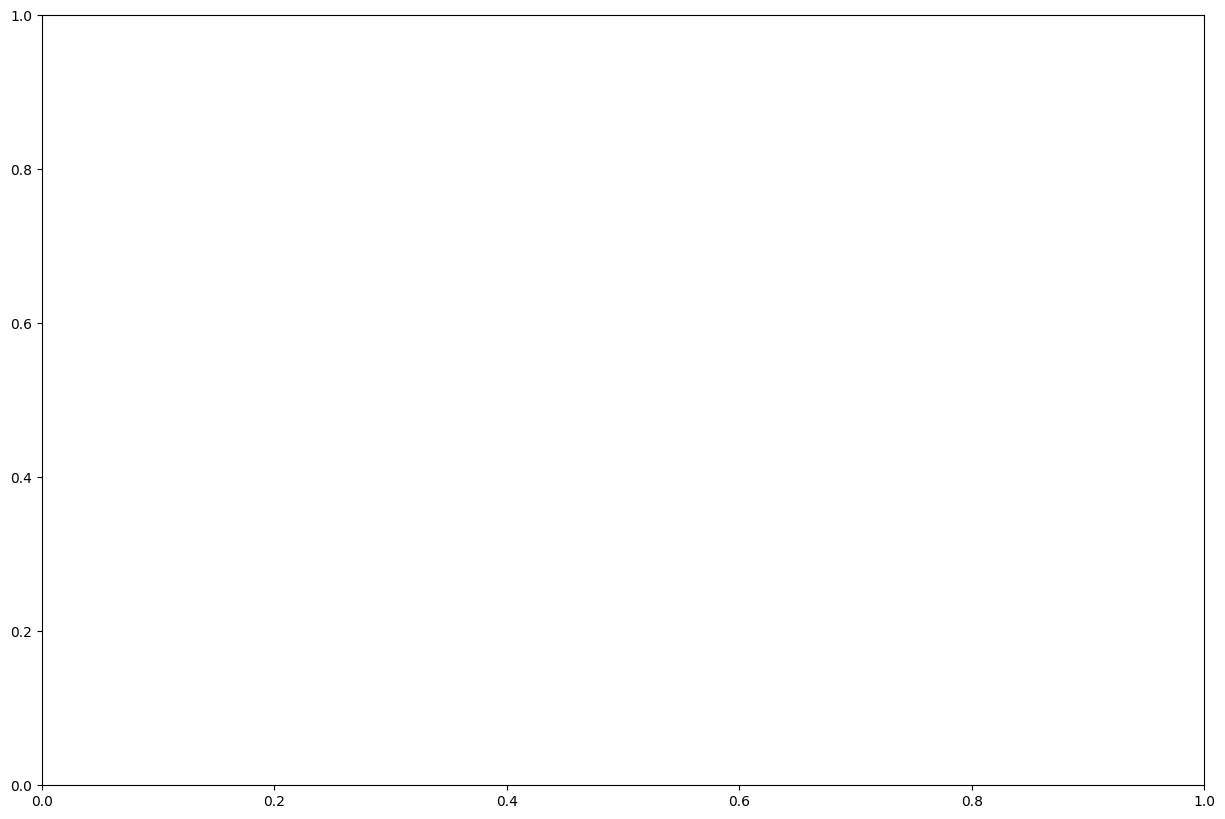

In [83]:
f, ax = plt.subplots(figsize=(15, 10))
xgb_model.plot_importance(xgb_model, max_num_features=5, ax=ax);

In [78]:
optuna.visualization.plot_contour(study)

In [96]:
pwd

'/Users/dsjunkie'

In [79]:
# interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [80]:
# Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [81]:
optuna.visualization.plot_edf(study)

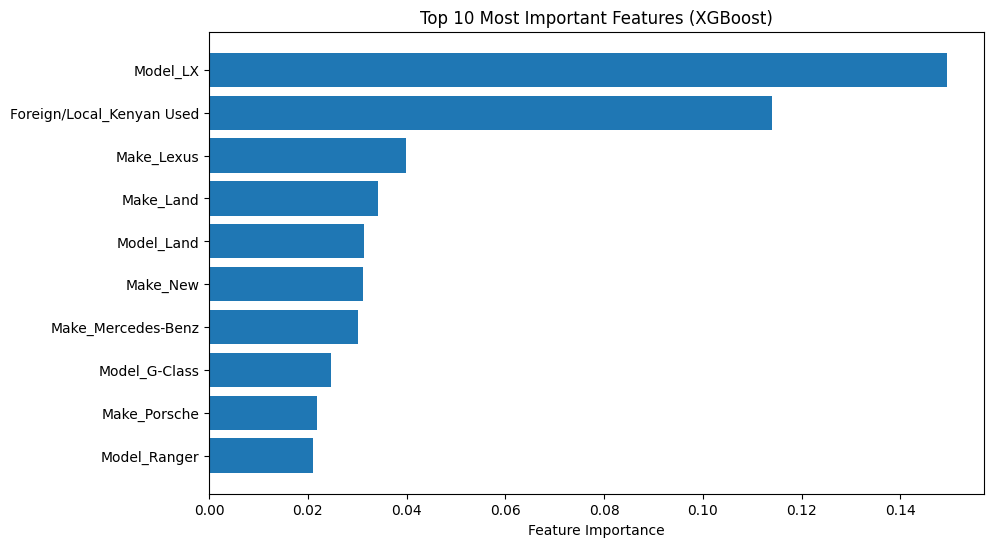

In [82]:
importances = xgb_model.feature_importances_

# Get feature names (replace with your feature names or column names)
feature_names = X.columns  # Replace with your feature names

# Create a bar plot to visualize feature importances
# Sort features by importance and get the top 10
top_10_indices = np.argsort(importances)[::-1][:10]
top_10_importances = importances[top_10_indices]
top_10_feature_names = [feature_names[i] for i in top_10_indices]

# Create a bar plot to visualize the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_importances)), top_10_importances, align="center")
plt.yticks(range(len(top_10_feature_names)), top_10_feature_names)
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features (XGBoost)")
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()

In [66]:
test_data = pd.read_csv('cars_j_test.csv')

In [68]:
test_data = test_data.drop(columns=['Price','Mileage'])

In [72]:
test_data = test_data.drop(columns=['Unnamed: 0'])

In [74]:
test_data.info

<bound method DataFrame.info of           Make    Model  Year   Color Foreign/Local Engine Type
0   Mitsubishi   Delica  2016   Black  Foreign Used   Automatic
1          BMW       X6  2016   Pearl  Foreign Used   Automatic
2        Lexus       RX  2016   Black  Foreign Used   Automatic
3        Mazda     CX-5  2016   Black  Foreign Used   Automatic
4       Toyota  Corolla  2016  Silver  Foreign Used   Automatic
..         ...      ...   ...     ...           ...         ...
95      Toyota     Land  2012    Gray   Kenyan Used   Automatic
96      Nissan     Leaf  2016   White  Foreign Used   Automatic
97       Volvo     XC90  2016   White  Foreign Used   Automatic
98       Honda      Fit  2017  Silver  Foreign Used   Automatic
99      Toyota     Land  2000   White   Kenyan Used   Automatic

[100 rows x 6 columns]>